아래 코드에서 테스트 에큐러시 계산에 버그가 있어요. 버그를 고치세요.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

grandient_step :  0
loss :            3.2771072

grandient_step :  100
loss :            0.06371044

grandient_step :  200
loss :            0.13003106

grandient_step :  300
loss :            0.14888659

grandient_step :  400
loss :            0.11333938

grandient_step :  500
loss :            0.02139921

grandient_step :  600
loss :            0.12947118

grandient_step :  700
loss :            0.027990332

grandient_step :  800
loss :            0.07031916

grandient_step :  900
loss :            0.029494377

grandient_step :  1000
loss :            0.04278173

grandient_step :  1100
loss :            0.038567785

test accur

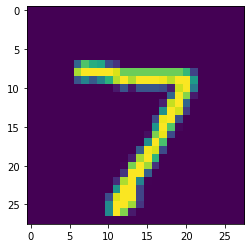

[7]


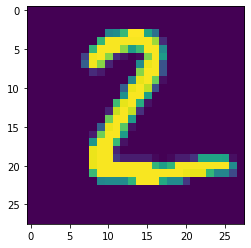

[2]


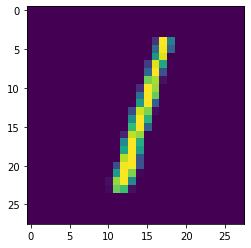

[1]


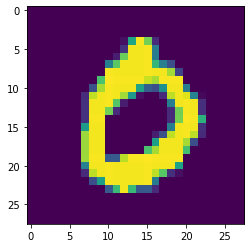

[0]


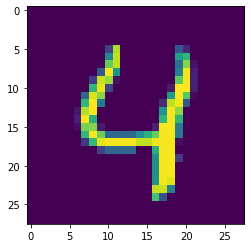

[4]


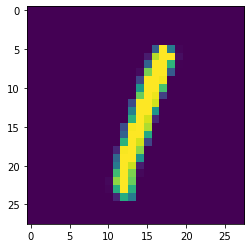

[1]


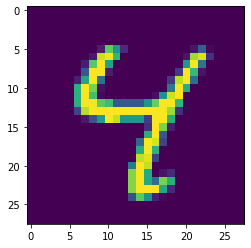

[4]


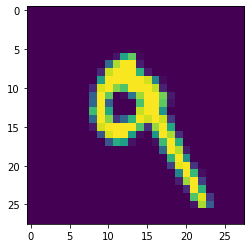

[9]


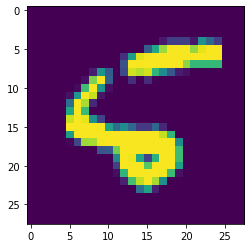

[5]


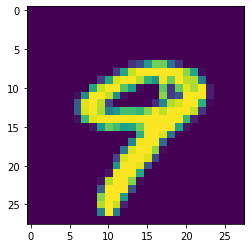

[9]


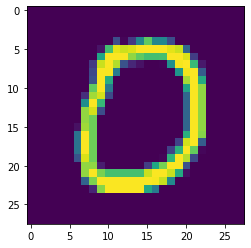

[0]


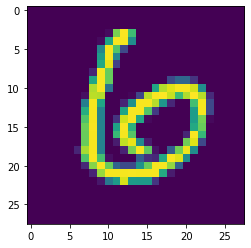

[6]


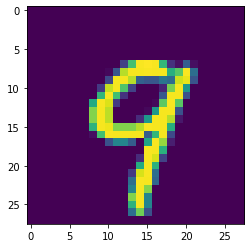

[9]


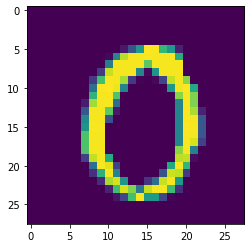

[0]


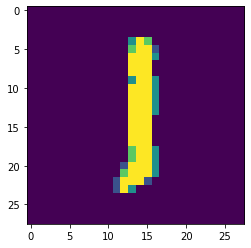

[1]


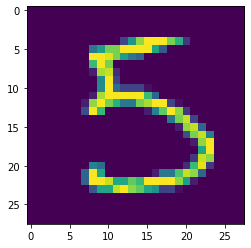

[5]


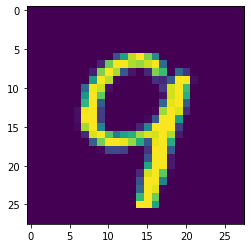

[9]


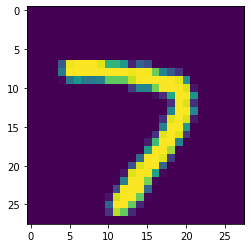

[7]


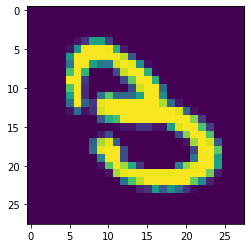

[3]


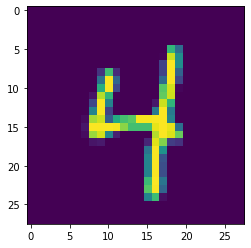

[4]


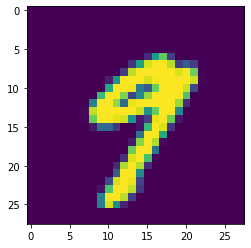

[9]


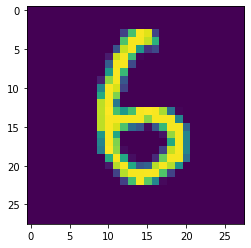

[6]


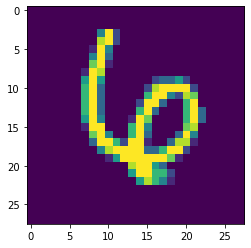

[6]


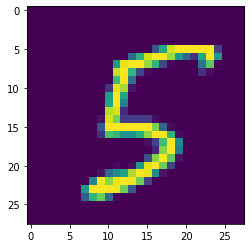

[5]


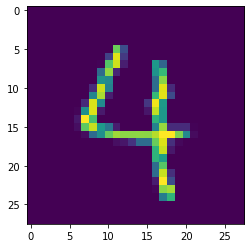

[4]


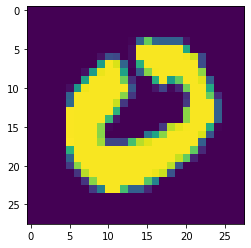

[0]


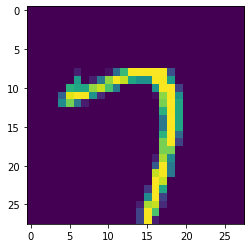

[7]


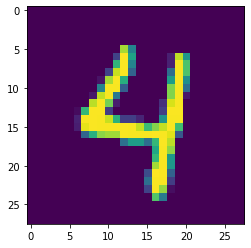

[4]


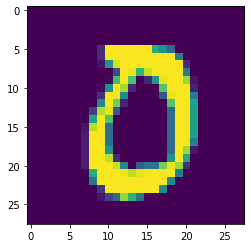

[0]


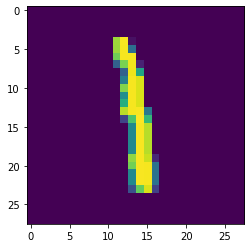

[1]


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

lr = 1e-3 
epoch = 2
batch_size = 100
report_period = 100

def shuffle_data(*args):
    idx = np.arange(args[0].shape[0])
    np.random.shuffle(idx)
    list_to_return = []
    for arg in args:
        list_to_return.append(arg[idx])
    return list_to_return

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 28, 28, 1)), x_test.reshape((-1, 28, 28, 1))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = y_train.copy().astype(np.int64).reshape((-1,1))
y_test_cls = y_test.copy().astype(np.int64).reshape((-1,1))
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)
# print(x_train.dtype, y_train.dtype, y_train_cls.dtype, x_test.dtype, y_test.dtype, y_test_cls.dtype)
# print(x_train.shape, y_train.shape, y_train_cls.shape, x_test.shape, y_test.shape, y_test_cls.shape)

np.random.seed(0)
tf.set_random_seed(0)

x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='x') # x:0
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
y_cls = tf.placeholder(tf.int64, shape=[None, 1], name='y_cls')
is_train = tf.placeholder(tf.bool, shape=[], name='is_train')

initializer = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG")

W1 = tf.get_variable("W1", shape=[5, 5, 1, 32], initializer=initializer)  # 800
y1 = tf.nn.conv2d(input=x, filter=W1, strides=[1, 1, 1, 1], padding='SAME')
y1 = tf.nn.max_pool(value=y1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y1 = tf.nn.relu(y1)

W2 = tf.get_variable("W2", shape=[5, 5, 32, 64], initializer=initializer)  # 51200
y2 = tf.nn.conv2d(input=y1, filter=W2, strides=[1, 1, 1, 1], padding='SAME')
y2 = tf.nn.max_pool(value=y2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y2 = tf.nn.relu(y2) 
y2 = tf.reshape(y2, [-1, 3136])

W3 = tf.get_variable("W3", shape=[3136, 100], initializer=initializer)  # 313600
y3 = tf.nn.relu(y2@W3) 
y3 = tf.contrib.layers.batch_norm(y3, is_training=is_train,
                                  center=True, scale=True, decay=0.9)

W4 = tf.get_variable("W4", shape=[100, 10], initializer=initializer)  # 1000
logits = tf.identity(y3@W4, name='logits')
prob = tf.nn.softmax(logits, name='prob')
y_pred_cls = tf.argmax(logits, axis=1, name='y_pred_cls')

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
cost = tf.reduce_mean(entropy)
update_ops = tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

correct_bool = tf.equal(y_pred_cls, y_cls, name='correct_bool')
correct_counter = tf.reduce_sum(tf.cast(correct_bool, tf.float32), name='correct_counter')
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), name='accuracy')

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    grandient_step = -1
    for _ in range(epoch):
        x_, y_, y_cls_ = shuffle_data(x_train, y_train, y_train_cls)
        for i in range(x_train.shape[0] // batch_size):
            x_batch = x_[i * batch_size:(i + 1) * batch_size]
            y_batch = y_[i * batch_size:(i + 1) * batch_size]
            y_batch_cls = y_cls_[i * batch_size:(i + 1) * batch_size].reshape((-1, 1))
            feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls, is_train: True}
            grandient_step += 1
            if grandient_step % report_period == 0:
                cost_run, _ = sess.run([cost, opt], feed_dict=feed_dict)
                print('grandient_step : ', grandient_step)
                print('loss :           ', cost_run)
                print()
            else:
                sess.run(opt, feed_dict=feed_dict)
                
    test_total = 10000
    accuracy_sum = 0
    sum_index = 0
    for i in range(test_total // batch_size):
        x_batch = x_test[i * batch_size:(i + 1) * batch_size]
        y_batch = y_test[i * batch_size:(i + 1) * batch_size]
        y_batch_cls = y_test_cls[i * batch_size:(i + 1) * batch_size].reshape((-1, 1))
        feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls, is_train: False}
        accuracy_run = sess.run(accuracy, feed_dict=feed_dict)
        accuracy_sum += accuracy_run
        sum_index += 1
    print('test accuracy:', accuracy_sum/sum_index)
    
    saver = tf.train.Saver()
    save_dir = 'result/model/'
    save_path = 'result/model/model_1'
    if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
    saver.save(sess=sess, save_path=save_path)
    print("save done")
      
with tf.Session() as sess:

    save_path = 'result/model/model_1'
    saver = tf.train.import_meta_graph(save_path + '.meta', clear_devices=True)
    saver.restore(sess=sess, save_path=save_path)

    x = sess.graph.get_tensor_by_name('x:0')
    y = sess.graph.get_tensor_by_name('y:0')
    y_cls = sess.graph.get_tensor_by_name('y_cls:0')
    is_train = sess.graph.get_tensor_by_name('is_train:0')
    y_pred_cls = sess.graph.get_tensor_by_name('y_pred_cls:0')
    correct_bool = sess.graph.get_tensor_by_name('correct_bool:0')
    correct_counter = tf.reduce_sum(tf.cast(correct_bool, tf.float32), name='correct_counter')
    
    test_total = 10000
    correct_counter_sum = 0
    for i in range(test_total // batch_size):
        x_batch = x_test[i * batch_size:(i + 1) * batch_size]
        y_batch = y_test[i * batch_size:(i + 1) * batch_size]
        y_batch_cls = y_test_cls[i * batch_size:(i + 1) * batch_size].reshape((-1, 1))
        feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls, is_train: False}
        correct_counter_run = sess.run(correct_counter, feed_dict=feed_dict)
        correct_counter_sum += correct_counter_run
        print(correct_counter_sum)
    print('test accuracy:', correct_counter_sum/test_total)
    
    for i in range(30):
        plt.imshow(x_test[i].reshape((28, 28)))  # (28,28,1) -> (28,28)
        plt.show()
        feed_dict = {x: [x_test[i]], is_train: False}  # (28,28,1) -> (1,28,28,1)
        print(sess.run(y_pred_cls, feed_dict=feed_dict))